# Sheet 6

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# 1) Top tagging with CNNs

In [2]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data06"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "toptagging-short.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data06

100%|██████████| 7/7 [00:00<00:00,  9.88it/s]


 Volume in Laufwerk C: hat keine Bezeichnung.
 Volumeseriennummer: DE2C-D233

 Verzeichnis von c:\Users\Games\Desktop\mlph2023-Exercises\data06

03.12.2023  12:01    <DIR>          .
03.12.2023  10:03    <DIR>          ..
03.12.2023  10:03    <DIR>          toptagging-short
03.12.2023  10:03        68.105.824 toptagging-short (1).zip
03.12.2023  10:05        68.105.824 toptagging-short (2).zip
03.12.2023  10:20        68.105.824 toptagging-short (3).zip
03.12.2023  10:30        68.105.824 toptagging-short (4).zip
03.12.2023  11:40        68.105.824 toptagging-short (5).zip
03.12.2023  12:01        68.105.824 toptagging-short (6).zip
03.12.2023  10:03        68.105.824 toptagging-short.zip
               7 Datei(en),    476.740.768 Bytes
               3 Verzeichnis(se), 489.392.291.840 Bytes frei


In [3]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

# shape: (events, particles, 4-momenta)
# 4-momenta are ordered as (E, px, py, pz)
# y are the labels (1 for signal=top jet, 0 for background=QCD jet)
print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


(a)

In [4]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [5]:
# needs roughly 3GB of RAM in orig_image
# reduce the number of events in the dataset if needed
z_train = constit_to_img( X_train, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


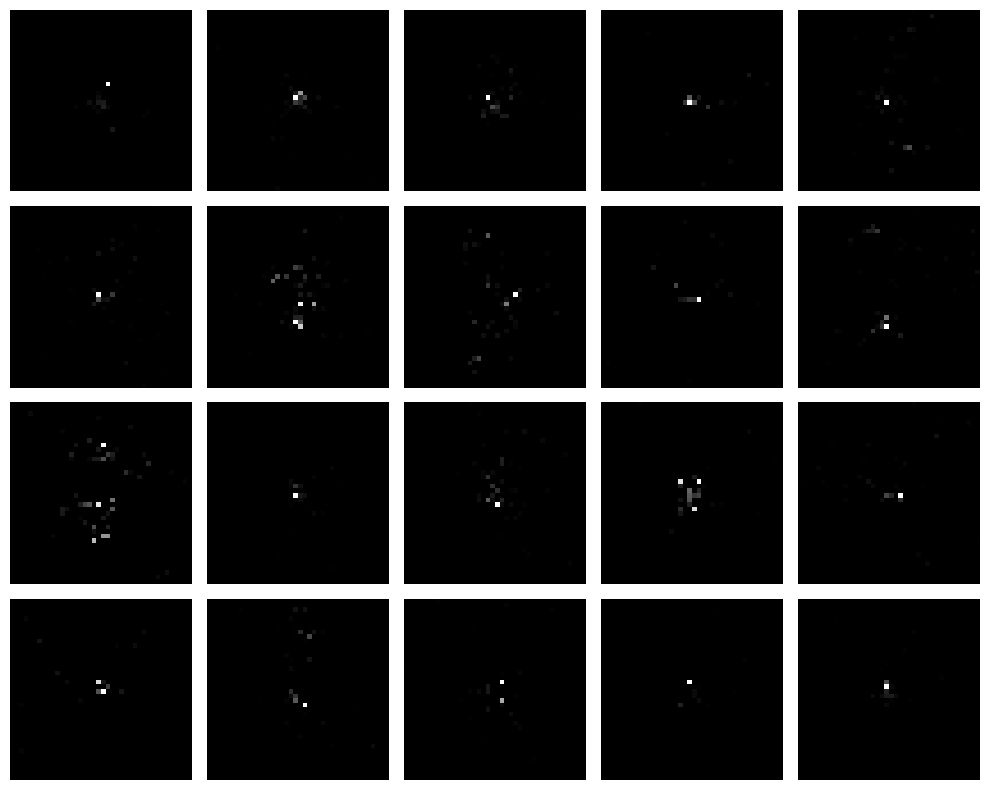

In [6]:

num_images = 20
rows = 4
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

for i in range(num_images):
    ax = axes[i // cols, i % cols]
    ax.imshow(z_train[i,0], cmap='gray')  # Hier könnte die entsprechende Farbkarte angepasst werden
    ax.axis('off')

plt.tight_layout()
plt.show()

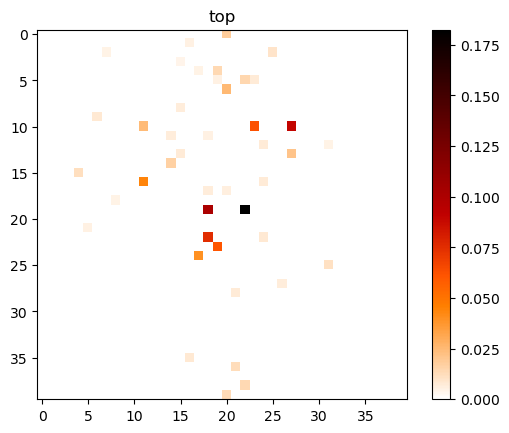

In [7]:
# TODO: Plot image of a top and QCD jet
# Use cmap='gist_heat_r' for nice visualization
plt.title('top')
plt.imshow(z_train[-1,0],cmap='gist_heat_r')
plt.colorbar()

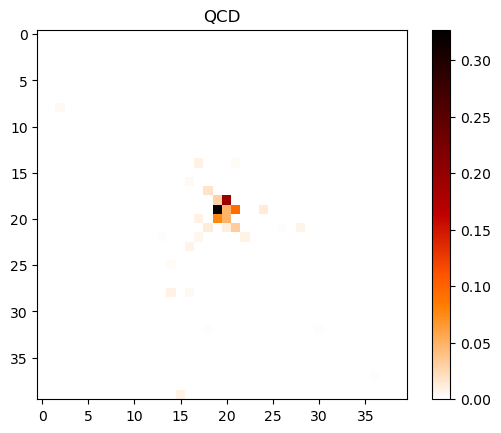

In [8]:
plt.title('QCD')
plt.imshow(z_train[1,0],cmap='gist_heat_r')
plt.colorbar()

In [9]:
# TODO: Plot image of the mean top and the mean QCD jet
# by averaging over all the respective images in the dataset
z_train1=z_train[y_train==1].squeeze()
z_train0=z_train[y_train==0].squeeze()

In [10]:
mean0im=np.mean(z_train0,axis=0)
mean1im=np.mean(z_train1,axis=0)

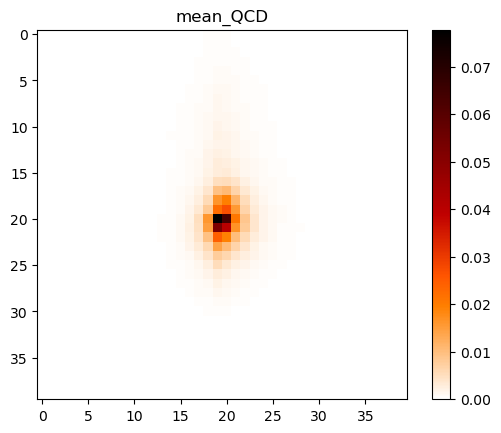

In [11]:
plt.title('mean_QCD')
plt.imshow(mean0im,cmap='gist_heat_r')
plt.colorbar()

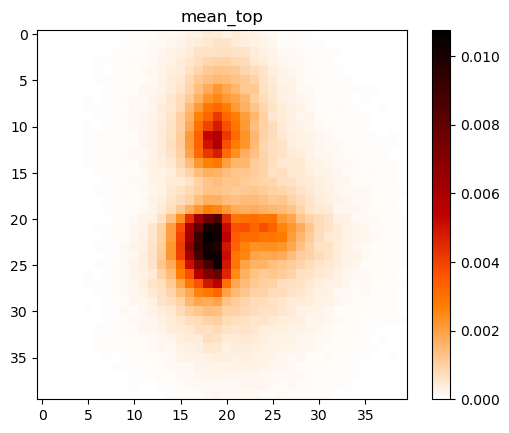

In [12]:
plt.title('mean_top')
plt.imshow(mean1im,cmap='gist_heat_r')
plt.colorbar()

(b)

In [13]:
# TODO: Implement your own BCE loss
def my_BCELoss(scores, labels):
    pass

In [14]:
# TODO: Compare implementation with nn.BCELoss

(c)

In [41]:
# TODO: Implement and train CNN
# TODO: Design a CNN
class CNN(torch.nn.Module):
    def __init__(self):
# call parent constructor
        super(CNN,self).__init__()
        # define layers
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 8,kernel_size = 8)
        self.ReLU1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels = 8, out_channels = 8,kernel_size = 8)
        self.ReLU2 = torch.nn.ReLU()
        self.Linear = torch.nn.Linear(in_features = 8*9*9, out_features = 1)
        self.Sigmoid = torch.nn.Sigmoid() # since output should be between 0␣and 1
        self.maxpooling=torch.nn.MaxPool2d(kernel_size=3,stride=3)
# define forward pass
    def forward(self, x):
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), mode='circular')
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        x = self.maxpooling(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.Linear(x)
        x = self.Sigmoid(x)
        return x

In [42]:


def train_epoch(model, dataloader, loss_fn, losses,optimizer):
    model.train()
    for x, y in dataloader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y.unsqueeze(1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return losses

def val_epoch(model, dataloader, loss_fn, losses):
    model.eval()
    with torch.no_grad():  # Korrekte Verwendung von torch.no_grad()
        epoch_losses = []
        for x, y in dataloader:
            outputs = model(x)
            loss = loss_fn(outputs, y.unsqueeze(1))
            epoch_losses.append(loss.item())
        losses.append(np.mean(epoch_losses))  # Verwendung von np.mean für den Durchschnitt
    return losses
        
    

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader

# Annahme: data_array ist das Numpy-Array mit den Bildern und labels_array ist das Array mit den Labels
# data_array hat die Form (30000, 40, 40)
# labels_array hat die Form (30000,)

# class CustomDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         image = self.data[idx]
#         label = self.labels[idx]
#         # Konvertierung zu PyTorch Tensor und Hinzufügen einer zusätzlichen Dimension für den Kanal
#         image = torch.tensor(image, dtype=torch.64)
#         return image, label

# Erstellung einer Instanz des CustomDataset
#custom_dataset = CustomDataset(z_train, y_train)
z_train_tensor=torch.tensor(z_train,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
print(y_train_tensor.dtype)
training_data_tensor = torch.utils.data.TensorDataset(z_train_tensor,y_train_tensor)
data_loader=torch.utils.data.DataLoader(training_data_tensor,batch_size=128,shuffle=True)



torch.float32


In [53]:
torch.manual_seed(42)
model = CNN()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs=10
train_losses=[]
val_losses=[]
for epoch in range(n_epochs):
    train_epoch(model=model,dataloader=data_loader,loss_fn=loss_fn,losses=train_losses,optimizer=optimizer) 
    val_epoch(model=model,dataloader=data_loader,loss_fn=loss_fn,losses=val_losses)   
    if epoch%10==0:
        print(f"{epoch} / {n_epochs}")

0 / 10


In [48]:
# TODO: Plot loss
def evaluate():
    # plot loss
    plt.yscale("log")
    plt.plot(np.arange(len(train_losses)) / len(data_loader), train_losses)
    plt.plot(np.arange(len(val_losses)), val_losses)
    plt.show()

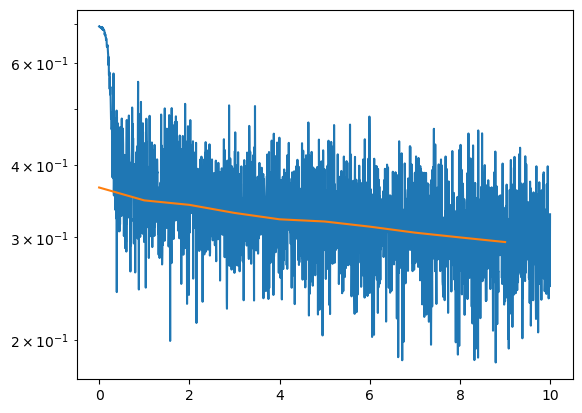

In [49]:
evaluate()

(d)

In [21]:
# TODO: Evaluate classifier

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

# TODO: Compute tpr, fpr, auc_score

In [23]:
# TODO: Plot ROC and SIC curve

# 2) Implementing Transformers with a Transformer

In [24]:
# TODO: Ask chatGPT for multi-headed self-attention
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        matmul_qk = torch.matmul(q, k.transpose(-2, -1))
        dk = torch.tensor(q.size(-1), dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, v)
        return output, attention_weights

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        output = self.dense(concat_attention)
        return output, attention_weights
